In [2]:
from __future__ import division
import random
import pprint
import sys
import time
import numpy as np
from optparse import OptionParser
import pickle
import cv2
import pandas as pd

from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Input
from keras.models import Model
from keras_frcnn import config, data_generators
from keras_frcnn import losses as losses
import keras_frcnn.roi_helpers as roi_helpers
from keras.utils import generic_utils
from keras_frcnn.mylayer import mylayer
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

K.set_learning_phase(1) #set learning phase

# sys.setrecursionlimit(40000)

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
network ='vgg'

if network == 'vgg':
	from keras_frcnn import vgg as nn
elif network == 'resnet50':
	from keras_frcnn import resnet as nn
else:
	print('Not a valid model')
	raise ValueError


In [4]:
from keras_frcnn.RoiPoolingConv import RoiPoolingConv
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout

if K.image_dim_ordering() == 'th':
	input_shape_img = (3, None, None)
else:
	input_shape_img = (400, 400, 3)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(6, 4))
nb_classes = 575

#pdb.set_trace()
num_rois = 6
# compile times on theano tend to be very high, so we use smaller ROI pooling regions to workaround

if K.backend() == 'tensorflow':
    pooling_regions = 4
    input_shape = (num_rois,4,4,512)
elif K.backend() == 'theano':
    pooling_regions = 7
    input_shape = (num_rois,512,7,7)

# define the base network (resnet here, can be VGG, Inception, etc)
shared_layers = nn.nn_base(img_input, trainable=True)


out_roi_pool = mylayer(pooling_regions, 6)([shared_layers, roi_input])
print out_roi_pool

out = (Flatten(name='flatten'))(out_roi_pool)
out = (Dense(4096, activation='relu', name='fc5'))(out)
out = (Dropout(0.5))(out)
out = (Dense(2048, activation='relu', name='fc6'))(out)
#out = (Dropout(0.5))(out)
#out = (Dense(512, activation='relu', name='fc7'))(out)
out_class = (Dense(1000, activation='sigmoid'))(out)

model_classifier = Model([img_input, roi_input], out_class)


try:
	print('loading weights from pretrained model')
	model_classifier.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels.h5', by_name=True)
except:
	print('Could not load pretrained model weights. Weights can be found in the keras application folder \
		https://github.com/fchollet/keras/tree/master/keras/applications')

optimizer = Adam(lr=1e-5)
optimizer_classifier = Adam(lr=1e-5)
model_classifier.compile(optimizer=optimizer_classifier, loss = 'binary_crossentropy', metrics= ['accuracy'])



Instructions for updating:
Colocations handled automatically by placer.
Tensor("mylayer_1/Reshape:0", shape=(1, 6, 4, 4, 512), dtype=float32)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
loading weights from pretrained model


In [5]:
def name(x):
    name = str.split(x,'/')
    return '/Users/1024329/Downloads/DeepFashion/img_n/' + name[1] + '/' + name[2]
    
df3 = pd.read_pickle('upper_body_atts.pkl')
df3['img_name'] = df3['img_name'].apply(lambda x:name(x))

In [6]:
df3 = df3[['img_name','landmarks','atts']]
df3.head()

,img_name,landmarks,atts
0,/Users/1024329/Downloads/DeepFashion/img_n/Lon...,"[[96, 2, 60, 60], [165, 2, 60, 60], [300, 153,...","[99, 495, 571, 881, 940]"
1,/Users/1024329/Downloads/DeepFashion/img_n/Hoo...,"[[105, 5, 60, 60], [255, 3, 60, 60], [26, 195,...","[470, 953]"
2,/Users/1024329/Downloads/DeepFashion/img_n/Rea...,"[[126, 36, 60, 60], [244, 42, 60, 60], [67, 3,...","[745, 883]"
3,/Users/1024329/Downloads/DeepFashion/img_n/Flo...,"[[67, 8, 60, 60], [217, 2, 60, 60], [24, 167, ...","[142, 306, 365]"
4,/Users/1024329/Downloads/DeepFashion/img_n/Bea...,"[[51, 68, 60, 60], [280, 80, 60, 60], [25, 13,...","[50, 121, 122, 226, 681]"


In [7]:
# removing the samples without any attribute present in it
sample = df3['atts'].apply(lambda x: x.shape[0]>0)
df4 =df3[sample]
df4.shape, df3.shape
# checking the maximum value of the attribute label
df4['atts'].apply(lambda x: np.max(x)).max()

# reset index of df4
df4 = df4.reset_index(drop = True)

In [19]:
def get_batch(num):
    img = []
    landmarks = []
    attribs = []
    b_size = 32
    for i in range(b_size*num, b_size*(num+1)):
        #print i
        a = cv2.imread(df4.loc[i,'img_name'])
        a = cv2.resize(a,(400,400))
        a = np.array(a).reshape(400,400,3)
        img.append(a/255)
        lnd = df4.loc[i,'landmarks']
        landmarks.append(lnd)
        atts = df4.loc[i,'atts']
        labels = np.array([0 if item not in atts else 1 for item in range(1000)]).reshape(1000,)
        attribs.append(labels)
    return np.array(img), (np.array(landmarks)/8).astype(int), np.array(attribs)

In [20]:
a,b,c = get_batch(3)

In [21]:
b[21]

array([[18,  0,  7,  7],
       [27,  1,  7,  7],
       [ 3, 31,  7,  7],
       [37, 26,  7,  7],
       [10, 43,  7,  6],
       [28, 44,  7,  5]])

In [22]:
model_classifier.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400, 400, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 400, 400, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 400, 400, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 200, 200, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [ ]:
train_loss = []
# train_acc = []
for j in range(50):
    print 'epoch number:', j
    los = 0
    acc = 0
    for i in range(2000):
        if i % 1000 ==0: print 'epoch and sample:', j, i
        X,X2,Y = get_batch(i)
        history = model_classifier.fit(x=[X,X2], y= Y, verbose = 2)
        los = los + np.array(history.history['loss'])
        #acc = acc + np.array(history.history['acc'])
        #print los
    train_loss.append(los)
    model_classifier.save_weights('roi_atts.h5')
    #train_acc.append(acc)
    print train_loss, train_acc
        

epoch number: 0
epoch and sample: 0 0
Epoch 1/1
 - 88s - loss: 0.7732 - acc: 0.4614
Epoch 1/1


In [93]:
xa,xb,ya = get_batch_new(10)
out_att = model_classifier.predict([xa,xb])

In [24]:
dfq = pd.read_csv('/Users/1024329/Downloads/DeepFashion/processed_data/list_attr_cloth.csv')

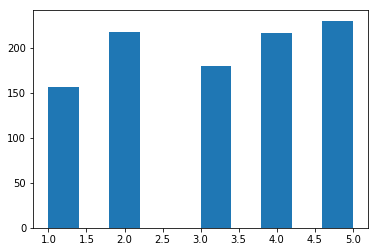

In [29]:
from matplotlib import pyplot as plt
plt.hist(dfq['att_type'])
plt.show()

In [95]:
print np.nonzero(ya>0), np.nonzero(out_att > 0.1)

(array([0]), array([30])) (array([0, 0, 0, 0]), array([ 9, 18, 22, 31]))


In [296]:
df5.head()

,img_name,landmarks,atts,select46_atts
0,/Users/1024329/Downloads/DeepFashion/img_n/Lon...,"[[96, 2, 60, 60], [165, 2, 60, 60], [300, 153,...","[99, 495, 571, 881, 940]","[495, 571]"
1,/Users/1024329/Downloads/DeepFashion/img_n/Hoo...,"[[105, 5, 60, 60], [255, 3, 60, 60], [26, 195,...","[470, 953]",[470]
2,/Users/1024329/Downloads/DeepFashion/img_n/Rea...,"[[126, 36, 60, 60], [244, 42, 60, 60], [67, 3,...","[745, 883]","[745, 883]"
3,/Users/1024329/Downloads/DeepFashion/img_n/Flo...,"[[67, 8, 60, 60], [217, 2, 60, 60], [24, 167, ...","[142, 306, 365]","[142, 365]"
4,/Users/1024329/Downloads/DeepFashion/img_n/Bea...,"[[51, 68, 60, 60], [280, 80, 60, 60], [25, 13,...","[50, 121, 122, 226, 681]",[226]


In [38]:
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)
# model_classifier.fit(x = [X,X2],y= Y, batch_size=1, epochs=2,validation_split=0.2,callbacks = [checkpoint])